## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
from collections import Counter
from IPython.display import clear_output


import string
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [4]:
text[:100]

['  From fairest creatures we desire increase,\n',
 "  That thereby beauty's rose might never die,\n",
 '  But as the riper should by time decease,\n',
 '  His tender heir might bear his memory:\n',
 '  But thou, contracted to thine own bright eyes,\n',
 "  Feed'st thy light's flame with self-substantial fuel,\n",
 '  Making a famine where abundance lies,\n',
 '  Thy self thy foe, to thy sweet self too cruel:\n',
 "  Thou that art now the world's fresh ornament,\n",
 '  And only herald to the gaudy spring,\n',
 '  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '\n',
 '  II\n',
 '\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n",
 "  Will be a tatter'd weed of small worth held:\n",
 '  Then being asked, where all thy beaut

As we can see sonnets have almost the same length, so let`s take a sample and find out the average len of one text.

In [5]:
text = ''.join(text)
sample = re.split('II|III|IV|V', text)[:6]
np.mean([len(t) for t in sample])

649.6666666666666

In [6]:
# so set SEQ_LEN as 650
SEQ_LEN = 650

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = text.lower()
# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Put all the characters, that you've seen in the text, into variable `tokens`.

In [9]:
tokens = sorted(set(text))
assert len(tokens) == 38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [10]:
# dict <index>:<char>
idx_to_token = dict((i, c) for i, c in enumerate(tokens))
# dict <char>:<index>
token_to_idx = dict((c, i) for i, c in enumerate(tokens))

In [11]:
sequence = np.array([token_to_idx[char] for char in text])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

__Define some functions for nets training__

In [12]:
BATCH_SIZE = 128

def get_batches(sequence: np.array, batch_size = BATCH_SIZE, seq_len=SEQ_LEN):
    '''
    Generate batches from the sequence of indices for network training; 
    '''
    total_size = batch_size * seq_len
    n_batches = len(sequence)//total_size    
    chunk = sequence[:n_batches * total_size]
    chunk = chunk.reshape((batch_size, -1))
    for n in range(0, chunk.shape[1], seq_len):
        train = chunk[:, n:n+seq_len]
        target = np.zeros_like(train)
        try:
            target[:, :-1], target[:, -1] = train[:, 1:], chunk[:, n+seq_len]
        except IndexError:
            target[:, :-1], target[:, -1] = train[:, 1:], chunk[:, 0]
        yield train, target

In [13]:
def one_hot_encode(sequence: np.array, n_labels: int):
    '''
    Converts encoded characters from integers to one-hot vectors
    '''
    ohe = np.zeros((np.multiply(*sequence.shape), n_labels), dtype=np.float32)    
    ohe[np.arange(ohe.shape[0]), sequence.flatten()] = 1.    
    ohe = ohe.reshape((*sequence.shape, n_labels))
    return ohe

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

__Did not implement__

Plot the loss function (axis X: number of epochs, axis Y: loss function).

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [20]:
class LSTM(nn.Module):
    
    def __init__(self, tokens, device=device, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()    
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden       
        self.n_tokens = len(tokens)
        self.idx_to_token = dict((i, c) for i, c in enumerate(tokens))
        self.token_to_idx = dict((c, i) for i, c in enumerate(tokens))

        self.lstm = nn.LSTM(self.n_tokens, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(n_hidden, self.n_tokens)
        
    def forward(self, x, hidden):
        r_output, hidden = self.lstm(x, hidden)
        out = self.dropout(r_output)
        out = out.contiguous().view(-1, self.n_hidden)        
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

Plot the loss function of the number of epochs. Does the final loss become better?

In [15]:
def train(model, data, device, optimizer, criterion, epochs=20, batch_size=BATCH_SIZE, seq_len=SEQ_LEN, clip=5):
    history = []
    model.train()
    
    for epoch in range(epochs):
        hid = model.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_len):
            # OHE data
            x = one_hot_encode(x, model.n_tokens)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            inputs, targets = inputs.to(device), targets.to(device)

            # zero accumulated gradients
            model.zero_grad()            
            output, hid = model(inputs, hid)
            
            # calculate loss
            loss = criterion(output, targets.view(batch_size*seq_len).long())
            loss.backward(retain_graph=True)
            
            # clip gradients to avoid exploding gradients,
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            history.append(loss.item())

        clear_output(True)
        plt.plot(history, label='loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        

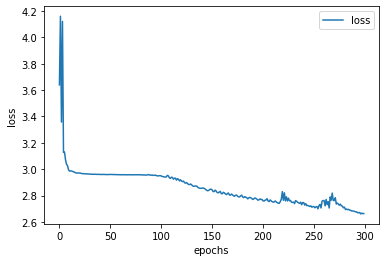

In [21]:
# define the model
n_hidden=512
n_layers=2
model = LSTM(tokens, device, n_hidden, n_layers).to(device)
epochs = 300 
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

# train the model
train(model, sequence, device, opt, criterion, epochs=epochs)